# Data Project
## Zachary Downing

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

"""
seed is used whenever a random value is needed, such as for cross validation, and set to 1 to make
results reproducible
"""
seed = 1

In [2]:
"""
Loading in the csv file as a Pandas dataframe
"""
df = pd.read_csv('Data_Project_Data.csv')

The following cells are for gathering info on the dataset and determining where missing values are present and need to be dealt with.


In [3]:
df.head()

,pitch_id,pitcher_id,pitcher_side,pitch_type,pitch_initial_speed_a,break_x_a,break_z_a,pitch_initial_speed_b,spinrate_b,break_x_b,break_z_b
0,1,15865,R,Fastball,89.7,-1.23,10.06,90.7214,2302.52,4.29402,-12.2448
1,2,15865,R,Fastball,89.9,-1.81,12.27,90.8140,2262.55,3.74221,-12.3771
2,3,15865,R,Fastball,91.9,-1.84,10.62,92.6839,2211.62,4.06159,-16.3200
3,4,15865,R,Fastball,90.7,-5.82,6.26,91.5610,2269.47,10.23910,-20.5354
4,5,15865,R,Fastball,88.9,-0.69,10.04,90.0486,2229.72,2.44025,-12.6229


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
pitch_id                 5000 non-null int64
pitcher_id               5000 non-null int64
pitcher_side             5000 non-null object
pitch_type               4000 non-null object
pitch_initial_speed_a    2997 non-null float64
break_x_a                2997 non-null float64
break_z_a                2997 non-null float64
pitch_initial_speed_b    2995 non-null float64
spinrate_b               2876 non-null float64
break_x_b                2976 non-null float64
break_z_b                2976 non-null float64
dtypes: float64(7), int64(2), object(2)
memory usage: 429.8+ KB


In [5]:
df.describe()

,pitch_id,pitcher_id,pitch_initial_speed_a,break_x_a,break_z_a,pitch_initial_speed_b,spinrate_b,break_x_b,break_z_b
count,5000.000000,5000.000000,2997.000000,2997.000000,2997.000000,2995.000000,2876.000000,2976.000000,2976.000000
mean,250.500000,183391.800000,87.942997,-1.140460,4.082066,88.371854,2178.986610,3.130157,-27.831781
std,144.351715,196610.939371,5.900053,6.889191,6.112909,5.923131,341.269569,10.939886,15.792680
min,1.000000,15865.000000,68.000000,-14.500000,-12.880000,68.639900,513.820000,-24.624900,-75.841300
25%,125.750000,34909.000000,84.100000,-6.970000,0.780000,84.616800,2062.160000,-6.754848,-37.333050
50%,250.500000,81283.000000,89.827000,-2.410000,6.010000,90.308600,2242.680000,4.564755,-22.336100
75%,375.250000,466401.000000,92.800000,4.660000,8.600000,93.141650,2381.352500,12.964025,-15.621025
max,500.000000,495134.000000,97.500000,15.260000,15.970000,98.328200,2934.170000,25.135600,-0.478330


The following are the pitch types present in the dataset, which in this case are the labels for training and predicion.

In [6]:
pitch_types = df.pitch_type.unique()
print(pitch_types)

['Fastball' 'Slider' 'Curveball' 'Changeup' nan]


The following are the number missing values in each column:

In [7]:
print(df.isna().sum())

pitch_id                    0
pitcher_id                  0
pitcher_side                0
pitch_type               1000
pitch_initial_speed_a    2003
break_x_a                2003
break_z_a                2003
pitch_initial_speed_b    2005
spinrate_b               2124
break_x_b                2024
break_z_b                2024
dtype: int64


Clearly the 100 pitch_type missing values belong to the test set we plan to predict. Other than that, there are many missing values in each feature except pitch_id and pitcher_id.

## Feature Selection and Engineering

This dictionary and inverse of the dictionary will be used to map labels from strings to integers, then Map pitch types from strings to these values (0, 1, 2, 3) using the dictionary pitch_mapping


In [8]:
pitch_mapping = {'Fastball': 0, 'Slider': 1, 'Curveball': 2, 'Changeup': 3}
inv_pitch_mapping = {v: k for k, v in pitch_mapping.items()}
print(pitch_mapping)
print(inv_pitch_mapping)

df['pitch_type'] = df['pitch_type'].map(pitch_mapping)

{'Fastball': 0, 'Slider': 1, 'Curveball': 2, 'Changeup': 3}
{0: 'Fastball', 1: 'Slider', 2: 'Curveball', 3: 'Changeup'}


For each of break_z, break_x, pitch_initial_speed, since we trust system B more, we are starting with the
values measured by system B and only filling in the missing values with those measured by system A, then adding these as new features called break_x, break_z, and pitch_initial_speed.
There are no spinrate_a measurements, so spinrate_b is simply renamed to spinrate.

In [9]:
break_z = df['break_z_b'].fillna(df['break_z_a'])
break_x = df['break_x_b'].fillna(df['break_x_a'])
pitch_initial_speed = df['pitch_initial_speed_b'].fillna(df['pitch_initial_speed_a'])

df['break_x'] = break_x
df['break_z'] = break_z
df['pitch_initial_speed'] = pitch_initial_speed
df = df.rename({'spinrate_b': 'spinrate'}, axis = 1)

Transform pitcher_side into a binary feature where 1 means the pitcher is right handed, 0 mean left handed.

In [10]:
df['pitcher_side'] = (df['pitcher_side'] == 'R').astype(int)

Features that will ultimately be used for prediction, as well as the prediction target pitch_type. I originally considering methods of imputing spinrate since it has a large number of missing values. I considered predicting spinrate and using that in the training dataset; however, I believe there are too many misisng values to make this a viable option and I chose to omit spinrate as a feature. I first omited pitcher_id but found that the model performed better with it included. I belive this is because a pitch of a particular type by a certain pitcher will be consistently similar.

These are the features I began examining and ended up ultimately using. From a non-analytic, purely real-world point of view, pitcher_side is important because it is realated to break_x, the horizontal break of a pitch. Both break variables and pitch_initial_speed are also likely important features because they are very indicative of a pitch type. For example, a fastball will have a high pitch_initial_speed and minimal break, whereas a curveball will have a low pitch_initial_speed, but much higher break. As I hypothesized, though model testing, these features proved important.

Between this analysis and testing different features, I found this to produce the highest accuracy through cross validation, and so I expect this to produce the most accurate predictions.

Interestingly, KNN gave a higher accuracy without pitcher_id, whereas Decision Forest gives a higher accuracy with it present. Ultimately Decision Forest gave a higher prediction, so I chose this model and to keep this feature present.

I considered engineering a feature based on pitch_side and break_x, the horizontal break, but based on the plot I could not find a strong enough relationship to do so, since break was distributed across the entire range regardless of handedness.

In [11]:
features = ['pitcher_id', 'pitcher_side', 'pitch_initial_speed', 'break_x', 'break_z']
target = 'pitch_type'

data = df[[target] + features]

The following are several plots to help illustrate the importance of variables as well as their relation. The first graph plots break_x against break_z, with pitch types color coded. The second plot is a heatmap of the pearson correlation of features, which is a method to determine how related to one another they are.

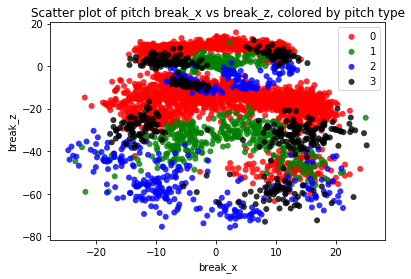

0: Fastball, 1: Slider, 2: Curveball, 3: Changeup


In [12]:
colors = ("red", "green", "blue", "black")
groups = (0, 1, 2, 3)
gb = data.groupby('pitch_type')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for color, group in zip(colors, groups):
    x = gb.get_group(group)['break_x']
    y = gb.get_group(group)['break_z']
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', label=group)

plt.title('Scatter plot of pitch break_x vs break_z, colored by pitch type')
plt.xlabel('break_x')
plt.ylabel('break_z')
plt.legend()
plt.show()

print("0: Fastball, 1: Slider, 2: Curveball, 3: Changeup")

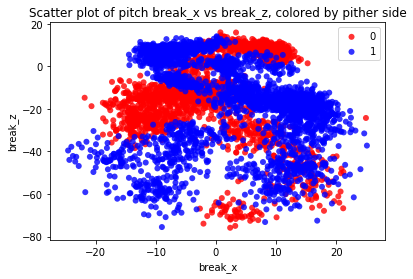

0 indicates a left-handed pitcher, 1 indicates a right-handed pitcher


In [13]:
colors = ("red", "blue")
groups = (0, 1)
gb = data.groupby('pitcher_side')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for color, group in zip(colors, groups):
    x = gb.get_group(group)['break_x']
    y = gb.get_group(group)['break_z']
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', label=group)

plt.title('Scatter plot of pitch break_x vs break_z, colored by pither side')
plt.xlabel('break_x')
plt.ylabel('break_z')
plt.legend()
plt.show()

print("0 indicates a left-handed pitcher, 1 indicates a right-handed pitcher")

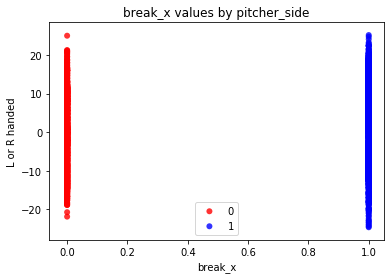

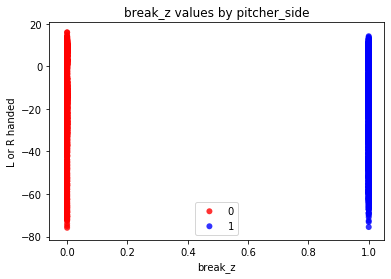

Frequency of break_x 


In [14]:
colors = ("red", "blue")
groups = (0, 1)
gb = data.groupby('pitcher_side')
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
for i, (color, group) in enumerate(zip(colors, groups)):
    y = gb.get_group(group)['break_x']
    x = [i] * len(y)
    ax1.scatter(x, y, alpha=0.8, c=color, edgecolors='none', label=group)

plt.title('break_x values by pitcher_side')
plt.xlabel('break_x')
plt.ylabel('L or R handed')
plt.legend()
plt.show()

fig = plt.figure()
ax2 = fig.add_subplot(1, 1, 1)
for i, (color, group) in enumerate(zip(colors, groups)):
    y = gb.get_group(group)['break_z']
    x = [i] * len(y)
    ax2.scatter(x, y, alpha=0.8, c=color, edgecolors='none', label=group)

plt.title('break_z values by pitcher_side')
plt.xlabel('break_z')
plt.ylabel('L or R handed')
plt.legend()
plt.show()

print("Frequency of break_x ")

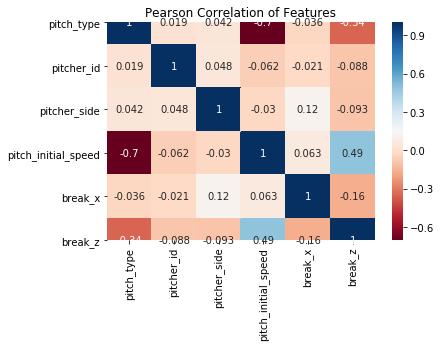

In [15]:
colormap = plt.cm.RdBu
plt.title('Pearson Correlation of Features')
sns.heatmap(data.astype(float).corr(), cmap=colormap, linecolor='white', annot=True)
plt.show()

Separate train and test data. Train data is the labeled data while test data in the unlabeled data, and as such has
a missing value in the pitch_type feature

In [16]:
train = data[data['pitch_type'].isnull() == False]
test = data[data['pitch_type'].isnull()]

In [17]:
# Number of missing training values:
print(train.isna().sum())

pitch_type             0
pitcher_id             0
pitcher_side           0
pitch_initial_speed    3
break_x                7
break_z                7
dtype: int64


In [18]:
# Number of missing test values:
print(test.isna().sum())

pitch_type             1000
pitcher_id                0
pitcher_side              0
pitch_initial_speed       1
break_x                   1
break_z                   1
dtype: int64


Despite merging the data from System A and System B, there are clearly still some missing values present in both the training and test data.

Imputing missing training training values based on the average of training data with the same label as the missing data.

In [19]:
train.pitch_initial_speed = train['pitch_initial_speed'].fillna(train.groupby('pitch_type')['pitch_initial_speed'].transform('mean'))
train.break_x = train['break_x'].fillna(train.groupby('pitch_type')['break_x'].transform('mean'))
train.break_z = train['break_z'].fillna(train.groupby('pitch_type')['break_z'].transform('mean'))

/Users/zacharydowning/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In the case of missing test data, I found it is most accurate by just using the average of the entire feature in the training set


In [20]:
test.pitch_initial_speed = test['pitch_initial_speed'].fillna(train['pitch_initial_speed'].mean())
test.break_x = test['break_x'].fillna(train['break_x'].mean())
test.break_z = test['break_z'].fillna(train['break_z'].mean())

In [21]:
X_train = train[features]
y_train = train[target]

X_test = test[features]

Normalizing (not standardizing) using sklearn's MinMaxScaler because each feature has a very different scale. This normalizes the scale of each feature to the range [0,1], which is common practice when features have a different scale. For example, pitch_initial_speed and break_x or break_z have very different ranges.

In [22]:
sc = MinMaxScaler()
sc.fit(X_train)
X_train_norm = sc.transform(X_train)
X_test_norm = sc.transform(X_test)

## Model Selection and  Hyperparameter Tuning

I chose these three models because they are generally regarded as strong supervised learning algorithms. Each has their own strengths and weaknesses. From a feature standpoint, this problem is relatively simple, and has a decent amount of traing data, so KNN should work well and a decision forest may not be necessary.
In each case I'll be using k-fold cross validation to tune some hyperparameters.

### KNN

The first model I considered in KNN. The data likely cannot be made to be linearly separable, and many pitches of the same type are alike, so this seems like a strong application for this supervised learning algorithm.

Note that when p=2 and metric is set to minkowski, this is using L2 norm distance measure.

In [23]:
neighbors = [x for x in range(1, 51)]
knn_accuracy = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
    scores = cross_val_score(knn, X_train_norm, y_train, cv=10, scoring='accuracy')
    knn_accuracy.append(scores.mean())


optimal_k_idx = knn_accuracy.index(max(knn_accuracy))
optimal_k = neighbors[optimal_k_idx]

opt_knn = KNeighborsClassifier(n_neighbors=optimal_k, p=2, metric='minkowski')

print('Best k value:', optimal_k, '\n')
print('Accuracy:', knn_accuracy[optimal_k_idx], '\n')

Best k value: 3 

Accuracy: 0.8663146112957335 



Here is a graph to show the accuracy when compared to the number of neighbors used in knn. It's clear that k = 3 is the best option.

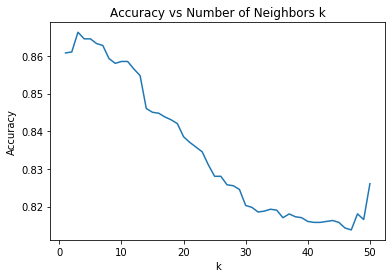

In [24]:
fig = plt.figure()
plt.plot(neighbors, knn_accuracy)
plt.title('Accuracy vs Number of Neighbors k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

### Random Forest Classification

I next considered a random forest. The features of this problem are quite simple, but this model is much more complex than KNN, so it may yield more accurate predictions.

In [25]:
param_grid = {
    'criterion': ['gini', 'entropy'],
#     'max_depth': [5, 8, 15, 25, 30, 40],
#     'min_samples_leaf': [1, 2, 5, 10],
#     'min_samples_split': [2, 10, 15, 50, 75, 100, 140],
    'n_estimators': [200, 250, 275, 300, 400, 600, 800, 1000, 1200]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
#grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 1)
#grid_search.fit(X_train_norm, y_train)
#print(grid_search.best_params_)


The result of the search is: {'criterion': 'entropy', 'n_estimators': 800} but it takes some time to run.

In [26]:
opt_forest = RandomForestClassifier(criterion='entropy', random_state=seed, n_estimators=800)
scores = cross_val_score(opt_forest, X_train_norm, y_train, cv=10, scoring='accuracy')
best_forest_acc = scores.mean()
print(best_forest_acc)


0.8921379069721102


### SVM

I also tuned parameters for, trained, and tested a nonlinear SVM model, but it was less accurate than both KNN and the forest classification, so I did not include it here.

## Prediction

The best model I tested for KNN was KNN with k = 3 and L2 norm (euclidean distance).

The best model I tested for Decision Forests was with criterion = entropy and n_estimators = 800. This ended up being slightly better than KNN when doing 10-fold cross validation to check the accuracy on the training data. I will use that model to predict the pitch_type labels for the test data. After fitting the model to the training data, the test labels are predicted. They are in the format (0, 1, 2, 3) described earlier, so using the inverted dictionary defined earlier, the pitches are mapped back to their real names.

The predicted values are printed here as well as saved in a .csv file called predictions.csv under column name pitch_type.

In [27]:
# opt_knn.fit(X_train_norm, y_train)
# final_pred = knn.predict(X_test_norm)

opt_forest.fit(X_train_norm, y_train)
final_pred = opt_forest.predict(X_test_norm)

translated_final_pred = [inv_pitch_mapping[x] for x in final_pred]

print('Ensure this value is 1000:', len(translated_final_pred),'\n')
if len(translated_final_pred) == 1000:
    print('Number of predicted values is as expected\n')

# Printout of all predictions:
print(translated_final_pred)

output_df = pd.DataFrame(translated_final_pred, columns=["pitch_type"])
output_df.to_csv('predictions.csv', index=False)

Ensure this value is 1000: 1000 

Number of predicted values is as expected

['Slider', 'Slider', 'Curveball', 'Slider', 'Slider', 'Fastball', 'Slider', 'Slider', 'Fastball', 'Fastball', 'Slider', 'Slider', 'Fastball', 'Fastball', 'Slider', 'Changeup', 'Curveball', 'Slider', 'Fastball', 'Fastball', 'Slider', 'Fastball', 'Fastball', 'Fastball', 'Curveball', 'Changeup', 'Curveball', 'Fastball', 'Fastball', 'Slider', 'Fastball', 'Fastball', 'Slider', 'Fastball', 'Fastball', 'Slider', 'Curveball', 'Slider', 'Slider', 'Slider', 'Fastball', 'Fastball', 'Fastball', 'Slider', 'Fastball', 'Fastball', 'Fastball', 'Slider', 'Fastball', 'Fastball', 'Fastball', 'Slider', 'Fastball', 'Fastball', 'Fastball', 'Slider', 'Fastball', 'Fastball', 'Fastball', 'Fastball', 'Fastball', 'Fastball', 'Fastball', 'Fastball', 'Fastball', 'Slider', 'Fastball', 'Fastball', 'Slider', 'Slider', 'Fastball', 'Fastball', 'Fastball', 'Fastball', 'Fastball', 'Fastball', 'Fastball', 'Fastball', 'Slider', 'Slider', 'Fastball

## Analysis

The result was an accurate model. Additionally, based on the results of this excercise, I believe that with more data and complete features, and potentially a more complex model, this can be extended to acurately predcit even more pitch types, which would be subtypes of these pitches, such as four-seam fastballs, cutters, etc.